In [1]:
import os
import sys

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from google.colab import drive
drive.mount('/content/drive')

!pip install loguru -q

# dir if needing change
base_dir = '/content/drive/My Drive/Risk Forecasting'
sys.path.append(base_dir)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00


## Test and Eval notebook

EECS MSc Project - Research Based - 2023 <br/><br/>
An Incremental Batch Learning Performance Assessment of CDS Implied Volatility n-step Estimation Approaches <br/><br/> Robert Taylor, Queen Mary, UoL

In [2]:
import numpy as np
import pandas as pd
import gc
import contextlib
import tensorflow as tf
import matplotlib.pyplot as plt
from loguru import logger
from pandas.plotting import table
from contextlib import redirect_stdout, redirect_stderr
from models import SVM, TFT_GRU, LGBM, Naive
from utils import ForecastStats, reconstruct_levels, rolling_test, plot_predictions_vs_actuals, plot_residuals, plot_residuals_violin

logger.remove()
logger.add("log.txt", level="CRITICAL")
logger.add(sys.stderr, level="INFO")

# matplotlib in latex style
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='stix')

device_name = tf.test.gpu_device_name()
if device_name:
    print(f'{device_name} found')
else:
    print("No GPU found")

tf.config.optimizer.set_jit(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

feature_matrix_path, target_vector_path = os.path.join(base_dir, 'features.pkl'), os.path.join(base_dir, 'RESPONSE Main 1m.xls')

feature_matrix = pd.read_pickle(feature_matrix_path)
target_vector = (pd.read_excel(target_vector_path, skiprows=range(6)).rename(columns=lambda x: x.strip()).assign(**{'Effective date': lambda df: pd
                .to_datetime(df['Effective date'], errors='coerce')}).dropna(subset=['Effective date']).set_index('Effective date'))

feature_matrix.index = pd.to_datetime(feature_matrix.index, errors='coerce')
target_vector.index = pd.to_datetime(target_vector.index, errors='coerce')

# take ln for stationarity
target_vector = np.log(target_vector).diff().dropna()

# set sample range and take intersection
train_index = feature_matrix.index.intersection(target_vector.index)

X = feature_matrix.loc[train_index]
y = target_vector.loc[train_index]

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/device:GPU:0 found


In [3]:
X = X.iloc[:, :5] # n features

print(f"X shape: {X.shape}")

X shape: (156, 5)


### test loop

In [4]:
predictions = 21  # subset at end of sliced observations dedicated to estimates (model will be fit on observations - predictions)
sequence_length = 5  # length of sequences (set to 5 for trading week)
window = 21
log_path = os.path.join(base_dir, 'full_log.txt')

In [5]:

with open(log_path, 'w') as f:
    with redirect_stdout(f), redirect_stderr(f):
        raw_metrics = {}
        levels_metrics = {}
        model_name_suffix = f' w {window}-period'

        # Naive model
        model_name = 'Naïve Forecast'
        raw_metrics[model_name] = rolling_test(
            Naive, X, y, chunk=(window + predictions), predictions=predictions, model_name=model_name
        )
        levels_metrics[model_name] = reconstruct_levels(target_vector, raw_metrics[model_name])

        del model_name
        gc.collect()

        # TFT-GRU model
        model_name = f'TFT-GRU{model_name_suffix}'
        with contextlib.redirect_stdout(sys.__stdout__):
            print(f'Training and rolling test for {model_name}')
        with tf.device('/device:GPU:0'):
            raw_metrics[model_name] = rolling_test(
                TFT_GRU, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name=model_name
            )
        levels_metrics[model_name] = reconstruct_levels(target_vector, raw_metrics[model_name])

        del model_name
        gc.collect()

        # SVM model
        model_name = f'SVM{model_name_suffix}'
        with contextlib.redirect_stdout(sys.__stdout__):
            print(f'Training and rolling test for {model_name}')
        raw_metrics[model_name] = rolling_test(
            SVM, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name=model_name
        )
        levels_metrics[model_name] = reconstruct_levels(target_vector, raw_metrics[model_name])

        del model_name
        gc.collect()

        # LightGBM model
        model_name = f'LightGBM{model_name_suffix}'
        with contextlib.redirect_stdout(sys.__stdout__):
            print(f'Training and rolling test for {model_name}')
        raw_metrics[model_name] = rolling_test(
            LGBM, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name=model_name
        )
        levels_metrics[model_name] = reconstruct_levels(target_vector, raw_metrics[model_name])

        del model_name
        gc.collect()

2024-08-04 16:57:34.938 | INFO     | utils:rolling_test:76 - Starting Naïve Forecast test
2024-08-04 16:57:34.941 | INFO     | utils:rolling_test:102 - Test 1/21
2024-08-04 16:57:35.361 | INFO     | utils:rolling_test:102 - Test 2/21
2024-08-04 16:57:35.764 | INFO     | utils:rolling_test:102 - Test 3/21
2024-08-04 16:57:36.165 | INFO     | utils:rolling_test:102 - Test 4/21
2024-08-04 16:57:36.571 | INFO     | utils:rolling_test:102 - Test 5/21
2024-08-04 16:57:36.976 | INFO     | utils:rolling_test:102 - Test 6/21
2024-08-04 16:57:37.374 | INFO     | utils:rolling_test:102 - Test 7/21
2024-08-04 16:57:37.781 | INFO     | utils:rolling_test:102 - Test 8/21
2024-08-04 16:57:38.199 | INFO     | utils:rolling_test:102 - Test 9/21
2024-08-04 16:57:38.608 | INFO     | utils:rolling_test:102 - Test 10/21
2024-08-04 16:57:39.023 | INFO     | utils:rolling_test:102 - Test 11/21
2024-08-04 16:57:39.431 | INFO     | utils:rolling_test:102 - Test 12/21
2024-08-04 16:57:39.850 | INFO     | utils:

### eval

In [6]:
# metrics, log returns
forecast_stats = ForecastStats(raw_metrics, X)
result_table = forecast_stats.calculate_forecast_stats()

result_table_path = os.path.join(base_dir, 'metrics_table.tex')
with open(result_table_path, 'w') as f:
    f.write(result_table.to_latex(index=False))

result_table

,Model,MAE,RMSE,Diebold-Mariano,Giacomini-White
0,Naïve Forecast,0.053938,0.074991,NaN,NaN
1,TFT-GRU w 21-period,0.054600,0.063856,0.09 (0.932),-0.05 (0.958)
2,SVM w 21-period,0.057333,0.070589,-0.65 (0.513),-0.40 (0.693)
3,LightGBM w 21-period,0.051838,0.061646,0.09 (0.931),0.05 (0.960)


In [7]:
# metrics, levels
level_metrics_table = forecast_stats.calculate_level_metrics(levels_metrics)

level_metrics_table_path = os.path.join(base_dir, 'level_metrics_table.tex')
with open(level_metrics_table_path, 'w') as f:
    f.write(level_metrics_table.to_latex(index=False))

level_metrics_table

/content/drive/My Drive/Risk Forecasting/utils.py:205: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_levels = pd.concat([table_levels, pd.DataFrame(rows)], ignore_index=True)


,Model,MAPE,Log Loss
0,Naïve Forecast,5.421650,0.005624
1,TFT-GRU w 21-period,5.463653,0.004078
2,SVM w 21-period,5.811748,0.004983
3,LightGBM w 21-period,5.175187,0.003800


### plots

In [8]:
models = ['TFT-GRU', 'SVM', 'LightGBM']

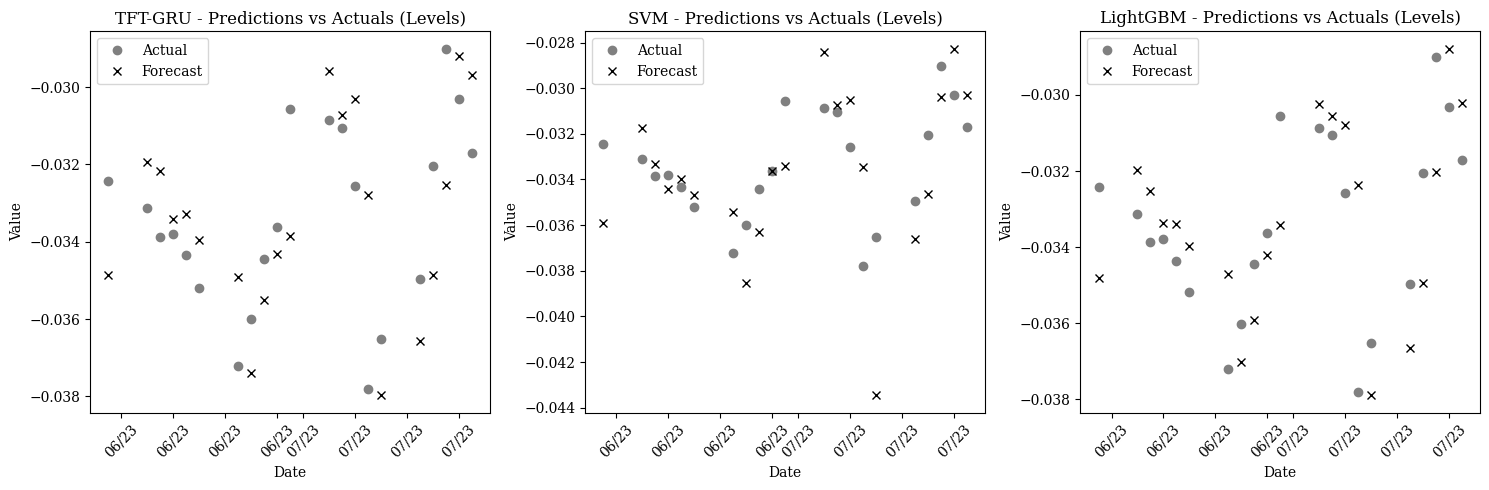

In [9]:
plot_predictions_vs_actuals(levels_metrics, models, model_name_suffix, window)

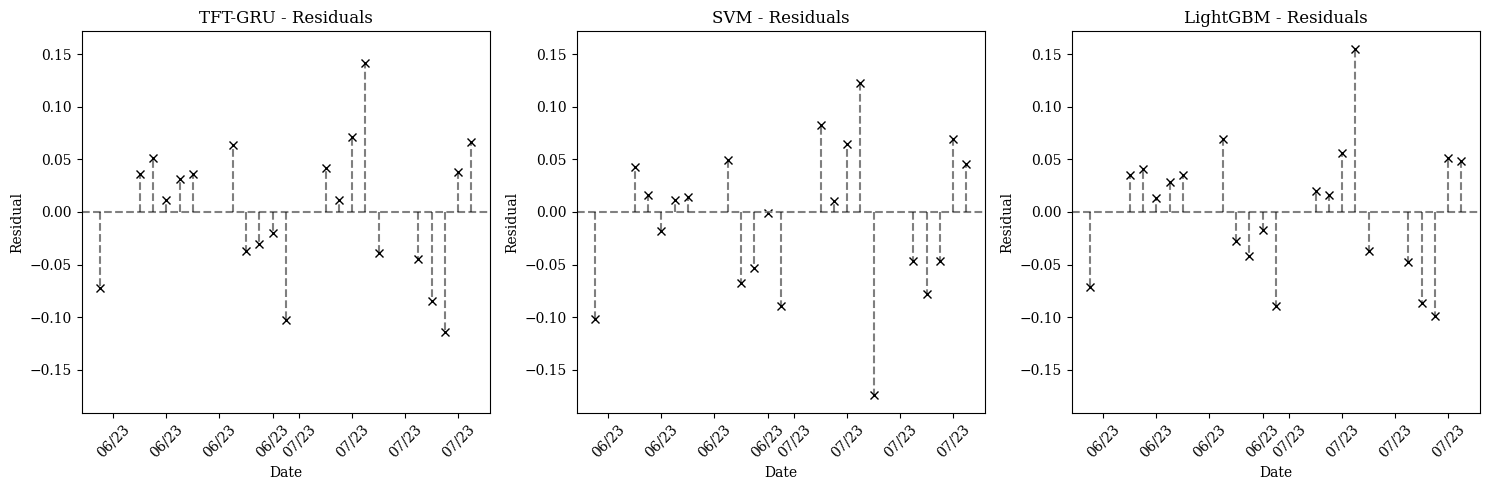

In [10]:
plot_residuals(raw_metrics, models, model_name_suffix, window)

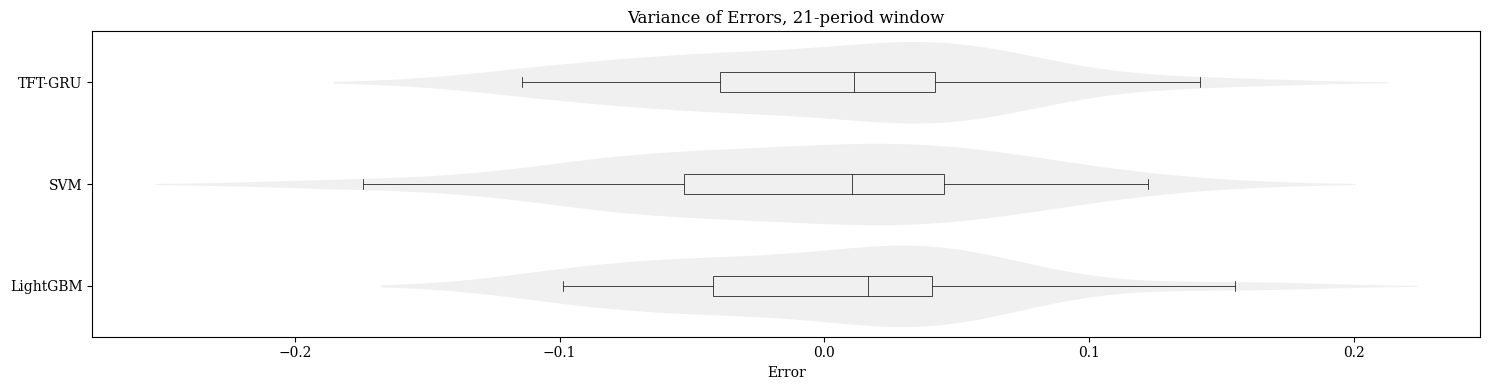

In [11]:
all_residuals = []
for model in models:
    suffix = f'{model}{model_name_suffix}'
    residuals = np.array(raw_metrics[suffix]['actuals']) - np.array(raw_metrics[suffix]['forecasts'])
    all_residuals.append(residuals)

plot_residuals_violin(all_residuals, models, window)